# Cepstrum-Based Deconvolution for Speech Dereverberation

In [23]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
#%matplotlib notebook
import librosa, librosa.display
import pyroomacoustics as pra
import scipy.signal as signal
from scipy.io import wavfile
import IPython.display as ipd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import soundfile as sf

In [24]:
fs = 4000 # sampling rate (Hz)

rt60_tgt = 0.4  # reverberation time (s)
room_dim = [7.62, 4.57, 2.13]  # room dimensions (m)

source_pos = [0.31, 1.22, 1.22] # x, y, z position of the source (m)
mic_locs = np.c_[ [1.52, 2.13, 1.22], [2.44, 1.52, 1.22]] # location of the microphone / microphone array (m)

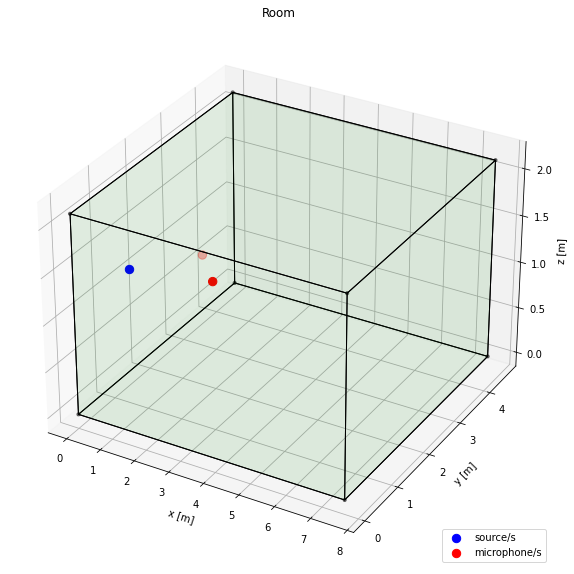

In [25]:
# vertices of the room
v = np.array([[0, 0, 0], [room_dim[0], 0, 0], [room_dim[0], room_dim[1], 0], [0, room_dim[1], 0], [0, 0, room_dim[2]], [room_dim[0], 0, room_dim[2]], [room_dim[0], room_dim[1], room_dim[2]], [0, room_dim[1], room_dim[2]]])

# room, sources and mics plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(source_pos[0], source_pos[1], source_pos[2], c='b', s=70)
ax.scatter(mic_locs[0, :], mic_locs[1, :], mic_locs[2, :], c='r', s=70)

ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s=10, c='k', alpha=0.5)

# generate list of sides' polygons of our room
walls = [ [v[0],v[1],v[2],v[3]], [v[4],v[5],v[6],v[7]], [v[2],v[3],v[7],v[6]], [v[0],v[3],v[7],v[4]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]] ]

# plot sides
ax.add_collection3d(Poly3DCollection(walls, facecolors='green', linewidths=1, edgecolors='k', alpha=0.05))

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Room')
ax.legend(('source/s','microphone/s'), loc='lower right', frameon=True);

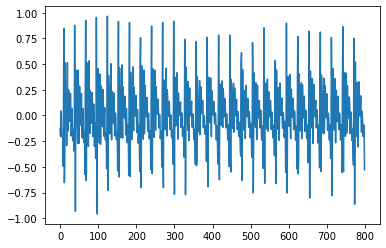

In [26]:
# import a mono wavfile as the source signal: the sampling frequency should match that of the room
audio, fs = librosa.load('audio/voiced_a.wav', sr=fs)
audio=audio[:800]

plt.figure()
plt.plot(audio)

In [27]:
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order);

# volume of the room
print("The volume of the room is {} m\u00b3".format(room.get_volume()))

The volume of the room is 74.1738510131836 m³


In [28]:
# place the source in the room
room.add_source(source_pos, signal=audio); #delay=0.5

# place the microphone array in the room
room.add_microphone_array(mic_locs);

In [29]:
# Run the simulation (this will also build the RIR automatically)
room.simulate()

# Save the reverberated audio into a file
room.mic_array.to_wav(
    f"audio/generated/voiced_aREV.wav",
    norm=True,
    bitdepth=np.int16,
)

x_rev = room.mic_array.signals[0, :];

global_delay = pra.constants.get("frac_delay_length") // 2

print('Global delay introduced by the simulation:', global_delay)

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {} s".format(rt60_tgt))
print("The measured RT60 is {} s".format(rt60[0, 0]))

Global delay introduced by the simulation: 40
The desired RT60 was 0.4 s
The measured RT60 is 0.77075 s


Original signal: (800,)
RIR1: (1, 6458)
RIR2: (1, 6448)
Reverberated signal, mic 1: (7258,)
Reverberated signal, mic 2: (7258,)


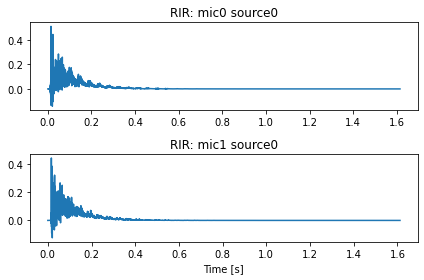

In [30]:
# Plot the RIRs
room.plot_rir()

print('Original signal:', audio.shape)
print('RIR1:', np.asarray(room.rir[0]).shape )
print('RIR2:', np.asarray(room.rir[1]).shape )
print('Reverberated signal, mic 1:', np.asarray(room.mic_array.signals[0, :]).shape)
print('Reverberated signal, mic 2:', np.asarray(room.mic_array.signals[1, :]).shape)

In [31]:
# x1:
x1 = room.mic_array.signals[0, :]
ipd.display(ipd.Audio(x1, rate=fs))

In [32]:
# x2:
x2 = room.mic_array.signals[1, :]
ipd.display(ipd.Audio(x2, rate=fs))

In [33]:
# UTILITIES

sig_length = len(x1)
N_samples = int(pow(2, np.ceil(np.log(sig_length)/np.log(2))))

def real_ceps(x,n=N_samples):
    spectrum = np.fft.fft(x, n=n) 
    ceps = np.fft.ifft(np.log(np.abs(spectrum))).real
    return ceps

def complex_ceps(x,n=N_samples):
    spectrum = np.fft.fft(x, n=n) 
    ceps = np.fft.ifft(np.log(spectrum)).real
    return ceps

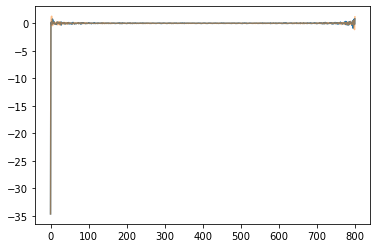

In [34]:
# WINDOWING
# apply window to x (wet signal) VEDI ARTICOLO

x3 = np.convolve(x1, x2)
alpha = 0.75
win1 = alpha**np.arange(len(x1))
win2 = alpha**np.arange(len(x2))
win3 = alpha**np.arange(len(x3))

x1w = win1*x1
x2w = win2*x2
x3w = win3*x3

c1w = complex_ceps(x1w, n=800)
c2w = complex_ceps(x2w, n=800)
c3w = complex_ceps(x3w, n=800)

plt.figure()
plt.plot(c3w)
plt.plot(c1w+c2w, alpha=0.5)

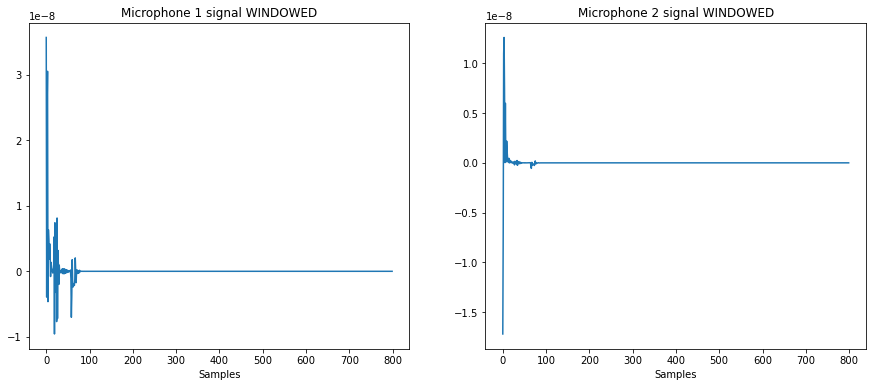

In [35]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(x1w[:800]) # CUT 800 samples
plt.title("Microphone 1 signal WINDOWED")
plt.xlabel("Samples")
plt.subplot(1,2,2)
plt.plot(x2w[:800])
plt.title("Microphone 2 signal WINDOWED")
plt.xlabel("Samples");

### Cepstrum based deconvolution for speech dereverberation

In [36]:
# FFTs, cepstrum -> apply function
K = N_samples

# ceps
X1 = np.fft.fft(x1w, n=K)
X1_hat = np.log(X1)

X1_hat_mag = np.abs(X1_hat)
X1_hat_ph = np.angle(X1_hat)

X1_hat_phu = np.unwrap(X1_hat_ph) # PHASE UNWRAP?

X1_hat_u = X1_hat_mag*np.exp(1j*X1_hat_phu) # CORRECT?


# repeat same for x2w

X2 = np.fft.fft(x2w, n=K)
X2_hat = np.log(X2)

X2_hat_mag = np.abs(X2_hat)
X2_hat_ph = np.angle(X2_hat)

X2_hat_phu = np.unwrap(X2_hat_ph) # PHASE UNWRAP?

X2_hat_u = X2_hat_mag*np.exp(1j*X2_hat_phu)

In [37]:
# phi min/max calculation:

# construct W
W = np.zeros((N_samples), dtype=np.complex)
m =np.arange(N_samples//2)

for lam in tqdm(range(N_samples)):
    W[lam] = np.sum(np.exp(-1j*(2*np.pi/N_samples)*m*lam)) # FFT? no...

X_diff = (X1_hat_u-X2_hat_u)

# phi min:
phi_min = np.imag(np.convolve(X_diff, W, mode='same')) # CONVOLUTION, same?

# phi max:
phi_max=np.imag(np.convolve(X_diff, np.conjugate(W), mode='same'))

100%|████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:02<00:00, 3514.37it/s]


In [38]:
# d_min e d_max (errors)

# REAL or COMpLEX?

# c1=real_ceps(x1)
# c2=real_ceps(x2)

c1=complex_ceps(x1w)
c2=complex_ceps(x2w)

# plt.figure()
# plt.plot(np.imag(c2))
# plt.plot(np.imag(c1))
# plt.xlim([0,2])
# print(c1[347])

d_min = c1-c2
d_max = np.flip(c1)-np.flip(c2)
# print(d_max.shape)

In [39]:
# # parametri Ml, Mh, L

# def h_est(phi,d,N_samples,len_tot,eps,L=2, Ml=L, Mh=):
#     H=np.ones((1,N_samples))
#     k=np.arange(N_samples)
#     M = Mh-Ml+1
#     m_vec = np.arange(Ml, Mh+1)

    
#     for l in tqdm(range(L, len_tot)):
        
#         for m in m_vec:
#             v = (l-L)*M + m - Ml
#             Y=np.abs(H)*np.exp(1j*(phi+2*(np.pi/N_samples)*m*k))
#             y=np.squeeze(np.fft.ifft(Y))
#             T2_y=np.zeros(N_samples, dtype=np.complex)
#             T2_y[0:l]=y[0:l]
#             h=T2_y
            
#             # error calculation
#             H=np.fft.fft(h)
            
#             d_it=np.angle(H) # h?
#             e=np.sum((d-d_it)**2)
            
#             errors.append(e)
#             dmin_it.append(d_it)
            
#             if e<=eps: 
#                 return m,l,h
            
        
#     return 0,0,0

In [40]:
# FOR ciclo da rivedere

def h_est(phi, d, N_samples, len_tot, threshold):
    H=np.ones((1,N_samples)) # 1st iteration (eq 10)
    k=np.arange(N_samples)
    Eps = [] # initialize error
    
    for l in tqdm(range(2,len_tot)):
        
        for m in range(l):
            Y=np.abs(H)*np.exp(1j*(phi+2*(np.pi/N_samples)*m*k)) # phase sustitution (eq 11)
            
            y=np.squeeze(np.fft.ifft(Y)) # T1
            
            # initialize T2_y
            T2_y=np.zeros(N_samples, dtype=np.complex)
            
            T2_y[0:l]=y[0:l] # time limiting (eq 12)
            h = T2_y
            
            # error calculation
            H=np.fft.fft(h)
            
            d_it=np.angle(H) # h or H? what does it mean "fourier phases"?
            
            e=np.sum((d-d_it)**2) # error computation
            
            Eps.append(e) # "non limited" error visualization
            
            if e <= threshold: 
                return m, l, h, Eps
            # do we need to return m, l? h returns 0!
                
    return None, None, None, Eps

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 14.97it/s]


Did not reach convergence! Change threshold...


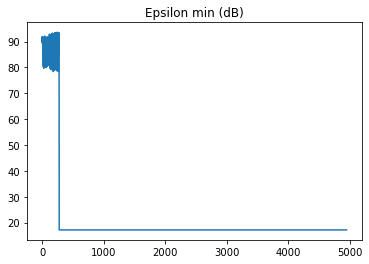

In [60]:
len_tot = 100 # len(room.rir[0][0])+len(room.rir[1][0])+1
th=8 # sotto 7 non converge
th = 7 # perchè il grafico crolla e rimane piatto?!

p2_plus, L_min, h_min, Eps_min = h_est(phi_min,d_min,N_samples,len_tot,th)

plt.figure()
plt.plot(librosa.amplitude_to_db(Eps_min))
plt.title("Epsilon min (dB)")


if(p2_plus == None or L_min == None):
    print("Did not reach convergence! Change threshold...")
else:
    print(p2_plus,L_min)

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.32it/s]


Did not reach convergence! Change threshold...


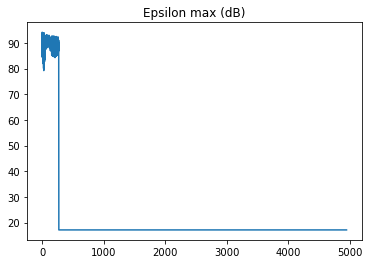

In [61]:
p2_minus, L_max, h_max, Eps_max = h_est(phi_max,d_max,N_samples,len_tot,th)

plt.figure()
plt.plot(librosa.amplitude_to_db(Eps_max))
plt.title("Epsilon max (dB)")


if(p2_minus or L_max == None):
    print("Did not reach convergence! Change threshold...")
else:
    print(p2_minus,L_max)


In [62]:
# estimate h1, h2 from h_max and h_min

print(h_min)

# h_min_hat = complex_ceps(h_min, n=len(h_min))

# h_max_hat = complex_ceps(h_max, n=len(h_max))

# h1_est_hat = np.flip(h_max_hat).append(h_min_hat)

# h2_est_hat = h_max_hat.append(np.flip(h_min_hat))

None


In [44]:
# apply channel inversion using kennedy?